# Max Regression

A demo of the toy max-regression problem from the paper. These models learn to approximate the largest number in the given set, regardless of the order presented.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import tf_utils as tfu

import settransformer as stf

In [2]:
strategy = tfu.strategy.gpu(1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2022-07-22 15:57:12.056749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 15:57:12.057067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 15:57:12.062695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 15:57:12.062910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 15:57:12.063077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

---
## Data Generation

The following function generates a batch sets, each consisting of *length* numbers.

In [3]:
def gen_data(batch_size, length=5):
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    return x, y # (batch_size, length)

In [4]:
x, y = gen_data(3, 5)

In [5]:
print(x.shape, y.shape)

(3, 5) (3,)


In [6]:
x

array([[71, 57, 42,  6,  9],
       [61, 44, 74, 77, 14],
       [36, 95, 16, 65, 16]])

In [7]:
y

array([71, 77, 95])

---
## Model

This model learns to approximate the largest number in the given set of numbers, regardless of the order presented.

In [8]:
def create_model(
    embed_dim=64,
    num_heads=4,
    stack=2,
    use_layernorm=False,
    pre_layernorm=False,
    use_keras_mha=False # Use Keras' MHA implementation over the traditional Vaswani implementation
):
    y = x = keras.layers.Input((None,))
    y = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(y)
    y = keras.layers.Dense(embed_dim)(y)
    for _ in range(stack):
        y = stf.SetAttentionBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                use_layernorm=use_layernorm,
                pre_layernorm=pre_layernorm,
                use_keras_mha=use_keras_mha)(y)

    y = stf.PoolingByMultiHeadAttention(
            num_seeds=1,
            embed_dim=embed_dim,
            num_heads=1,
            use_layernorm=use_layernorm,
            pre_layernorm=pre_layernorm,
            use_keras_mha=use_keras_mha,
            is_final_block=True)(y)
    y = keras.layers.Dense(1)(y)
    y = keras.layers.Lambda(lambda x: tf.squeeze(x))(y)

    return keras.Model(x, y)

---
## Training

In [9]:
model = create_model(use_layernorm=True)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

In [10]:
x[:2]

array([[71, 57, 42,  6,  9],
       [61, 44, 74, 77, 14]])

In [11]:
model.predict(x[:2])

2022-07-22 15:57:13.941929: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


array([3.0948365, 3.0693417], dtype=float32)

In [12]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [13]:
history = model.fit(x, y, epochs=500, verbose=0)

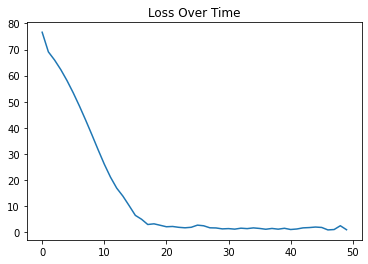

In [14]:
plt.plot(history.history["loss"][::10])
plt.title("Loss Over Time")
plt.show()

In [15]:
x[:3]

array([[51, 49, 43, 97, 89],
       [80, 70, 87, 89, 54],
       [29, 42, 50, 26, 77]])

In [16]:
model.predict(x[:3])

array([97.01486, 89.61533, 77.60927], dtype=float32)